# Depedency code

In [1]:
%run ../lib/cmdbench/bioinformatics/multibench.py

In [2]:
import os

os.environ['BIGSI_CONFIG'] = 'berkleydb.yaml'

# Software versions

In [3]:
!mccortex 31 2>&1 | grep version

version: mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31


In [4]:
!bigsi --version | grep bigsi-v

bigsi-v0.3.1


# Benchmarking

In [5]:
import sys
import os
import shutil
import numpy as np
import glob
import cmdbench

def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
            
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }

def sampling_func(input_size):
    return input_samples[:input_size]

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input-small'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

['SH12-002', 'SH09-29', 'MOD1_LS1005', 'SH12-005', 'CFSAN000961', 'SH12-007', 'SH14-005', 'CFSAN001112', 'CFSAN023467', 'SH11-001', 'SH14-010', 'SH14-024', 'CFSAN001115', 'SH12-012', 'CFSAN000970', 'MOD1_LS982', 'CFSAN000958', 'SH13-002', 'D7331', 'SH14-009', 'CFSAN000960', '2014D-0189', '2014C-3656', 'SH08-001', 'CFSAN001140', 'MOD1_LS1006', 'SH12-008', 'CFSAN023470', 'CFSAN023466', 'SH10-014', 'SH14-016', 'SH13-008', 'CFSAN000951', 'D7321', 'SH10-001', 'MOD1_LS997', 'CFSAN023464', '2014C-3907', 'SH13-007', 'PNUSA000195', 'CFSAN000752', 'CFSAN023469', 'CFSAN000661', 'SH14-023', 'SH14-014', 'CFSAN000191', 'PNUSAL000730', 'CFSAN000212', 'PNUSA000196', 'SH13-001', 'SH14-004', 'CFSAN023471', 'CFSAN000669', 'SH14-027', 'D7323', 'SH14-012', 'SH13-006', 'SH12-009', 'SH12-006', 'SH14-019', '2014D-0070', 'SH14-001', 'SH14-028', 'SH10-015', 'SH14-025', 'MOD1_LS1008', '2014D-0068', 'SH14-007', 'CFSAN023468', 'D7333', 'D7320', '2014C-3850', 'SH14-018', 'CFSAN000700', 'D7327', 'SH14-013', 'SH10-30

In [6]:
nproc=4
kmer=31

bigsi_dir = 'bigsi-data'
#sample_sizes = [1,20,60,100,140]
#sample_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
sample_sizes = [1,2,3,4,5]

def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists(bigsi_dir)
    clean_if_exists("test-berkeley.db")

mccortex_command = {
    "command": f"mccortex 31 build --nkmers 100000000 --threads 1 --kmer {kmer} --mem 20G" \
        + f" --sample % --seq2 {input_dir}/%_1.fastq.gz:{input_dir}/%_2.fastq.gz {bigsi_dir}/%.ctx",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_bloom_command = {
    "command": f"bigsi bloom -c berkleydb.yaml {bigsi_dir}/%.ctx {bigsi_dir}/%.bloom",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) \
        + " " + " ".join(list(map(lambda sample_file: f"{bigsi_dir}/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results, active_output_print = True, progress_bar = True)

>>>>>>>>>>>>>
parallel -j 4 -I% mccortex 31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample % --seq2 input-small/%_1.fastq.gz:input-small/%_2.fastq.gz bigsi-data/%.ctx ::: SH12-002

STDOUT: 
-------------
STDERR: [18 Jul 2020 12:06:41-YeW][cmd] /home/CSCScience.ca/apetkau/miniconda3/envs/cmdbench/bin/mccortex31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample SH12-002 --seq2 input-small/SH12-002_1.fastq.gz:input-small/SH12-002_2.fastq.gz bigsi-data/SH12-002.ctx
[18 Jul 2020 12:06:41-YeW][cwd] /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/bigsi
[18 Jul 2020 12:06:41-YeW][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31
[18 Jul 2020 12:06:41-YeW] Saving graph to: bigsi-data/SH12-002.ctx
[18 Jul 2020 12:06:41-YeW][sample] 0: SH12-002
[18 Jul 2020 12:06:41-YeW][task] input-small/SH12-002_1.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopolymers: off; remove PCR dup

# Save and reload results

In [7]:
save_path = "bigsi-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

save_multibench_results(multibench_results, samples_per_sample_size, save_path)

In [8]:
multibench_results, samples_per_sample_size = read_multibench_results(save_path)
print(samples_per_sample_size)

[['SH12-002'], ['SH12-002,', 'SH09-29'], ['SH12-002,', 'SH09-29,', 'MOD1_LS1005'], ['SH12-002,', 'SH09-29,', 'MOD1_LS1005,', 'SH12-005'], ['SH12-002,', 'SH09-29,', 'MOD1_LS1005,', 'SH12-005,', 'CFSAN000961'], ['SH12-002'], ['SH12-002,', 'SH09-29'], ['SH12-002,', 'SH09-29,', 'MOD1_LS1005'], ['SH12-002,', 'SH09-29,', 'MOD1_LS1005,', 'SH12-005'], ['SH12-002,', 'SH09-29,', 'MOD1_LS1005,', 'SH12-005,', 'CFSAN000961']]


# Plot

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

[{'runtime': 309.17, 'memory': 1092997120.0, 'disk_read': 153145451523.0, 'disk_write': 153217670019.0}, {'runtime': 336.76, 'memory': 2150735872.0, 'disk_read': 153147945739.0, 'disk_write': 153217072138.0}, {'runtime': 325.17, 'memory': 3237011456.0, 'disk_read': 153152025107.0, 'disk_write': 153217989785.0}, {'runtime': 322.08, 'memory': 4197810176.0, 'disk_read': 153156542747.0, 'disk_write': 153219382562.0}, {'runtime': 350.17, 'memory': 4289933312.0, 'disk_read': 153162821667.0, 'disk_write': 153222487473.0}]


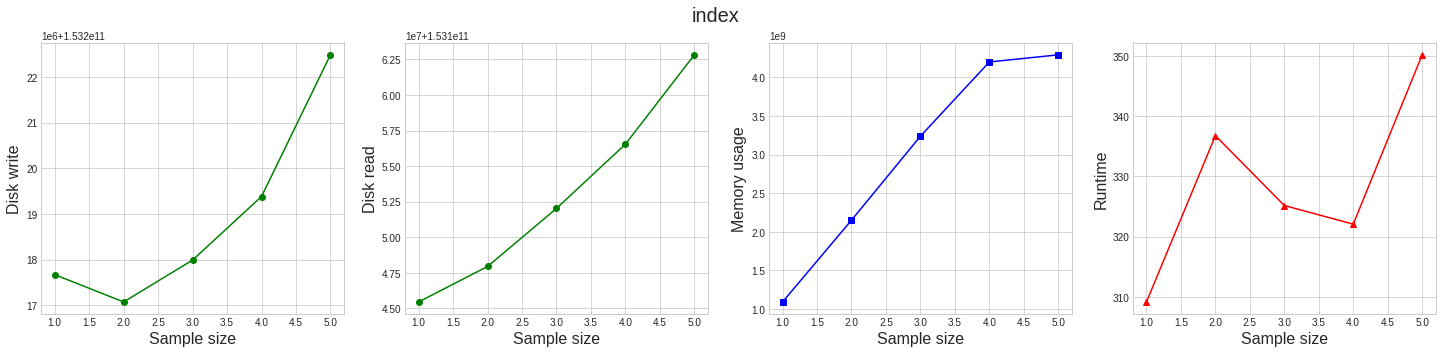

In [10]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 1.59, 'memory': 266043392.0, 'disk_read': 20437833.0, 'disk_write': 933119.0}, {'runtime': 1.57, 'memory': 265490432.0, 'disk_read': 20425300.0, 'disk_write': 931013.0}, {'runtime': 1.53, 'memory': 265408512.0, 'disk_read': 20425336.0, 'disk_write': 931021.0}, {'runtime': 1.58, 'memory': 265359360.0, 'disk_read': 20425341.0, 'disk_write': 931021.0}, {'runtime': 1.56, 'memory': 265756672.0, 'disk_read': 20425337.0, 'disk_write': 931018.0}]


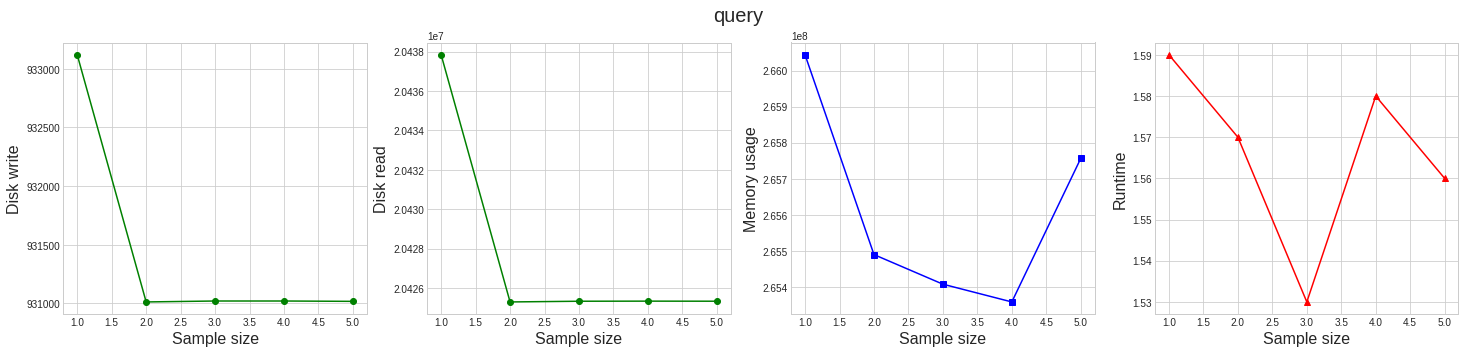

In [11]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")